# Load your dataset

Example data for one frame:
```
{
    "./sampledFrames/test_video/13260.jpg": 
    {
        "subject": ["man", "man", "glass", "window", "man"], 
        "relation": ["wearing", "wearing", "on", "on", "has"], 
        "object": ["glass", "shirt", "face", "car", "hair"], 
        "triplet": ["man wearing glass", "man wearing shirt", "glass on face", "window on car", "man has hair"]
    }
}
```

In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

def loadData() -> Data:
    # load data
    data = pd.read_json('../Datasets/scene-graph.json', orient='index')

    nodeIndex = {}
    edgeAttributeIndex = {}
    edge_attr = []
    edge_index = [[],
                  []]
    
    # encode subject nodes
    for node in data.loc['./sampledFrames/test_video/13260.jpg', 'subject']:
        if node not in nodeIndex:
            nodeIndex[node] = len(nodeIndex)
        edge_index[0].append(nodeIndex[node])

    # encode object nodes
    for node in data.loc['./sampledFrames/test_video/13260.jpg', 'object']:
        if node not in nodeIndex:
            nodeIndex[node] = len(nodeIndex)
        edge_index[1].append(nodeIndex[node])

    # encode edge attributes
    for edgeAttribute in data.loc['./sampledFrames/test_video/13260.jpg', 'relation']:
        if edgeAttribute not in edgeAttributeIndex:
            edgeAttributeIndex[edgeAttribute] = len(edgeAttributeIndex)
        edge_attr.append(edgeAttributeIndex[edgeAttribute])

    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.long).reshape(len(edge_index[0]), 1)
    dataset =  Data(edge_index=edge_index,
                    edge_attr=edge_attr,
                    num_nodes=len(nodeIndex),
                    x=torch.ones(len(nodeIndex), 1),
                    num_features=1)
    dataset.nodeIndex = nodeIndex
    dataset.edgeAttributeIndex = edgeAttributeIndex
    return dataset

from torch_geometric.datasets import KarateClub

dataset = loadData() # load your own dataset here
data = dataset
print(data)
print('==============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.edge_index)
print(data.edge_attr)

/home/ashmitchamoli/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data(
  x=[7, 1],
  edge_index=[2, 5],
  edge_attr=[5, 1],
  num_nodes=7,
  num_features=1,
  nodeIndex={
    man=0,
    glass=1,
    window=2,
    shirt=3,
    face=4,
    car=5,
    hair=6,
  },
  edgeAttributeIndex={
    wearing=0,
    on=1,
    has=2,
  }
)
Number of nodes: 7
Number of edges: 5
Average node degree: 0.71
Has isolated nodes: False
Has self-loops: False
Is undirected: False
tensor([[0, 0, 1, 2, 0],
        [1, 3, 4, 5, 6]])
tensor([[0],
        [0],
        [1],
        [1],
        [2]])


{'wearing': 0, 'on': 1, 'has': 2}


/home/ashmitchamoli/.local/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


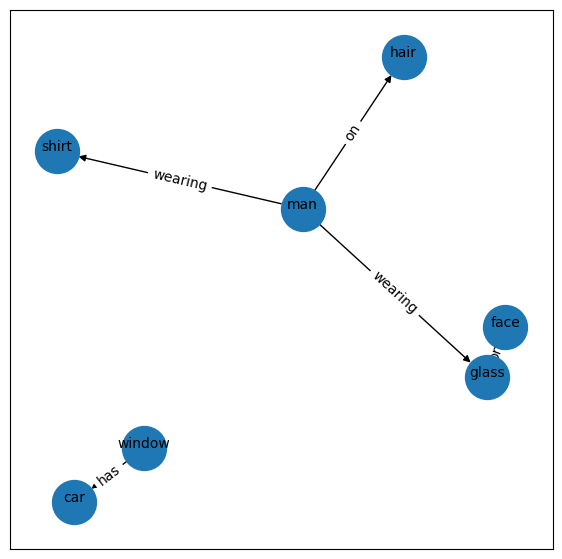

In [2]:
from torch_geometric.utils import to_networkx
import networkx as nx

def visualize_graph(G, color, nodeLabel, edgeLabels):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos=pos, with_labels=False,
                     node_color=color, cmap="Set2", node_size=1000, )
    # write labels on edges
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edgeLabels)
    
    # write labels on nodes
    for k, v in pos.items():
        plt.text(v[0], v[1], s=nodeLabel[k],
                 horizontalalignment='center', fontsize=10)
    plt.show()

G = to_networkx(dataset, 
                to_undirected=False)
print(dataset.edgeAttributeIndex)
visualize_graph(G,
                color=data.y, 
                nodeLabel={dataset.nodeIndex[k]: k for k in dataset.nodeIndex},
                edgeLabels=dict([((n1, n2), {v : k for k, v in dataset.edgeAttributeIndex.items()}[int(k[0])]) for k, (n1, n2) in zip(dataset.edge_attr, G.edges)]))

# GNN

In [3]:
import torch
from torch_geometric.nn import GCNConv, SAGEConv, aggr
import numpy as np

class GCN(torch.nn.Module):
    def __init__(self, numFeatures : int, embeddingSize : int = 2) -> None:
        super().__init__()
        torch.manual_seed(42)
        self.convLayers = []
        self.conv1 = GCNConv(numFeatures, embeddingSize)
        self.convLayers.append(self.conv1)
        self.nodeAggregator = aggr.MeanAggregation()
        
    def forward(self, x, edge_index):
        h = None
        for conv in self.convLayers:
            h = conv(x, edge_index)
            h = h.tanh()
            
        # now using these node level features, compute a graph level embedding
        graphEmbedding = self.nodeAggregator(h, torch.arange(1))

        return graphEmbedding

In [4]:
model = GCN(dataset.num_features, embeddingSize=2)
print(model)

graphEmbedding = model(data.x, data.edge_index)
# graph_embedding = scatter_mean(h, dataset.batch, dim=0)
print(graphEmbedding)

GCN(
  (conv1): GCNConv(1, 2)
  (aggregate): MeanAggregation()
)
tensor([[-2.4786,  6.2514]], grad_fn=<DivBackward0>)


In [5]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, imgEmbeddingSize : int, reducedImgEmbeddingSize : int, encoderHiddenLayers : list[int], sceneGraphEmbeddingSize : int, numClasses : int, n_peripheralInputs : int, feedForwardHiddenLayers : list[int]) -> None:
        super().__init__()

        self.imgEmbeddingSize = imgEmbeddingSize
        self.reducedImgEmbeddingSize = reducedImgEmbeddingSize
        self.encoderHiddenLayers = encoderHiddenLayers
        
        self.sceneGraphEmbeddingSize = sceneGraphEmbeddingSize
        self.n_peripheralInputs = n_peripheralInputs
        self.feedForwardHiddenLayers = feedForwardHiddenLayers

        self.numClasses = numClasses

        self.imgEmbeddingEncoder = torch.nn.Sequential()
        for i in range(len(self.encoderHiddenLayers)):
            linearLayer = torch.nn.Linear(self.imgEmbeddingSize if i == 0 else self,encoderHiddenLayers[i], 
                                          self.reducedImgEmbeddingSize if i == len(self.encoderHiddenLayers) - 1 else self.encoderHiddenLayers[i+1])
            self.imgEmbeddingEncoder.append(linearLayer)
            if i == len(self.encoderHiddenLayers) - 1:
                continue # ! which activation function to add at the end?
            else:
                self.imgEmbeddingEncoder.append(torch.nn.ReLU())
        
        if len(self.encoderHiddenLayers) == 0:
            linearLayer = torch.nn.Linear(self.imgEmbeddingSize, self.reducedImgEmbeddingSize)
            self.imgEmbeddingEncoder.append(linearLayer)
            # ! which activation function to add at the end?

        # define linear layer here
        self.feedForwardLayer = torch.nn.Sequential()
        n_feedForwardInputs = reducedImgEmbeddingSize + sceneGraphEmbeddingSize + n_peripheralInputs
        for i in range(len(self.feedForwardHiddenLayers)):
            linearLayer = torch.nn.Linear(n_feedForwardInputs if i == 0 else self.feedForwardHiddenLayers[i],
                                          self.numClasses if i == len(self.feedForwardHiddenLayers) - 1 else self.feedForwardHiddenLayers[i+1])
            self.feedForwardLayer.append(linearLayer)
            if i == len(self.feedForwardHiddenLayers) - 1:
                self.feedForwardLayer.append(torch.nn.Softmax(dim=1))
            else:
                self.feedForwardLayer.append(torch.nn.ReLU())

        if len(self.feedForwardHiddenLayers) == 0:
            linearLayer = torch.nn.Linear(n_feedForwardInputs, self.numClasses)
            self.feedForwardLayer.append(linearLayer)
            self.feedForwardLayer.append(torch.nn.Softmax(dim=1))
        
    def forward(self, imgEmbedding, sceneGraphEmbedding, peripheralInputs):
        imgEmbedding = self.imgEmbeddingEncoder(imgEmbedding)
        input = torch.cat((imgEmbedding, sceneGraphEmbedding, peripheralInputs), dim=1)
        return self.feedForwardLayer(input)


In [6]:
class DdPrediction(torch.nn.Module):
    def __init__(self, 
                 n_sceneGraphFeatures : int,
                 sceneGraphEmbeddingSize : int, 
                 imgEmbeddingSize : int, 
                 reducedImgEmbeddingSize : int, 
                 encoderHiddenLayers : list[int], 
                 numClasses : int, 
                 n_peripheralInputs : int, 
                 feedForwardHiddenLayers : list[int]) -> None:
        super().__init__()

        self.sceneGraphBlock = GCN(n_sceneGraphFeatures, sceneGraphEmbeddingSize)
        self.ffnnClassifierBlock = LinearClassifier(imgEmbeddingSize, reducedImgEmbeddingSize, encoderHiddenLayers, sceneGraphEmbeddingSize, numClasses, n_peripheralInputs, feedForwardHiddenLayers)

    def forward(self, imgEmbedding, sceneGraphEmbedding, peripheralInputs):
        sceneGraphEmbedding = self.sceneGraphBlock(sceneGraphEmbedding)
        return self.ffnnClassifierBlock(imgEmbedding, sceneGraphEmbedding, peripheralInputs)

    def train(self, data):
        pass
